In [13]:
import os 
import sys
import json
import pickle

import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

# Define the path to the dataset
base_path = os.path.join(os.path.dirname(os.getcwd()))
base_path

'/root/geonhee/express/PlayerImputer'

In [14]:
from datatools.trace_snapshot import TraceSnapshot
from datatools.utils import compute_camera_coverage, is_inside
import imputer.config as config

In [4]:
# 데이터 및 모델 경로
data_dir = os.path.join(base_path, "data" ,"DFL", "xgboost_include_role")
#model_path = os.path.join(base_path, "stores", "transformer", "000") # 036
model_path = os.path.join(base_path, "stores", "xgboost", "005") # 036
params_path = os.path.join(model_path, "params.json")

with open(params_path, "r") as f:
    all_params = json.load(f)
    # params = all_params.get("transformer", {})
    params = all_params.get("xgboost", {})

scaler_path = os.path.join(base_path, "imputer", "scalers")
params["save_path"] = model_path 
params["scaler_path"] = scaler_path 
params

{'ModelConfig': {'objective': 'reg:squarederror',
  'colsample_bytree': 0.8,
  'subsample': 0.3,
  'learning_rate': 0.015,
  'max_depth': 7,
  'gamma': 5,
  'n_estimators': 400,
  'enable_categorical': True,
  'n_jobs': -1,
  'tree_method': 'hist',
  'device': 'cuda',
  'verbosity': 1},
 'DataConfig': {'batch_size': 32, 'num_workers': 30, 'pin_memory': True},
 'save_path': '/root/geonhee/express/PlayerImputer/stores/xgboost/005',
 'scaler_path': '/root/geonhee/express/PlayerImputer/imputer/scalers'}

In [5]:
args_path = os.path.join(model_path, "args.json")
with open(args_path, "r") as f:
    args = json.load(f)
args

{'mode': 'train',
 'model': 'xgboost',
 'trial': 5,
 'params_file': 'imputer_params.json',
 'data_dir': 'data/DFL',
 'optimized_metric': None,
 'window': 5,
 'xfns': ['prevAgentX',
  'prevAgentY',
  'prevAgentTime',
  'nextAgentX',
  'nextAgentY',
  'nextAgentTime',
  'avgAgentX',
  'avgAgentY',
  'agentSide',
  'agentObserved',
  'goalDiff',
  'eventX',
  'eventY',
  'eventType'],
 'yfns': ['coordinates'],
 'test_only': False,
 'fold_mode': 'simple'}

In [6]:
# # 데이터셋 파일 경로 만들기
# dataset_filename = f'{args["model"]}_{args["window"]}_test_{"_".join(args["yfns"])}_dataset.pkl'
# # dataset_pkl_path = os.path.join(base_path, "data", "DFL", "freeze_frame_data", dataset_filename)
# #dataset_pkl_path = os.path.join(base_path, "data", "DFL", dataset_filename)
# dataset_pkl_path = os.path.join(base_path, "data", "DFL", dataset_filename)

# with open(dataset_pkl_path, "rb") as f:
#     test_dataset = pickle.load(f)
# test_dataset

In [7]:
from datatools.preprocess import extract_match_id
from imputer.datasets import ImputerDataset

data_dir = os.path.join(base_path, args["data_dir"])
game_ids = sorted([extract_match_id(filename) for filename in os.listdir(data_dir) if filename.startswith("DFL")])
#game_ids = sorted([extract_match_id(filename) for filename in os.listdir(data_dir)])
print(f"Game IDs: {game_ids}")
#test_game_ids = game_ids[31:34]
test_game_ids = game_ids[11:]
test_game_ids

Game IDs: ['DFL-MAT-J03WMX', 'DFL-MAT-J03WN1', 'DFL-MAT-J03WOH', 'DFL-MAT-J03WOY', 'DFL-MAT-J03WPY', 'DFL-MAT-J03WQQ', 'DFL-MAT-J03WR9', 'DFL-MAT-J03YHA', 'DFL-MAT-J03YIY', 'DFL-MAT-J03YKB', 'DFL-MAT-J03YKM', 'DFL-MAT-J03YKY', 'DFL-MAT-J03YLO']


['DFL-MAT-J03YKY', 'DFL-MAT-J03YLO']

In [8]:
test_dataset = ImputerDataset(
    game_ids=test_game_ids,
    data_dir=args["data_dir"],
    window=args["window"],
    model=args["model"],
    dataset="test",
    xfns=args["xfns"],
    yfns=args["yfns"],
    scaler_path=scaler_path
)

100%|██████████| 2/2 [00:42<00:00, 21.42s/it]


🚀 test's features_lst Shape: torch.Size([2979, 5, 40, 14])
🎯 test's labels_lst Shape: torch.Size([2979, 5, 40, 2])


In [9]:
# checkpoint_path = os.path.join(model_path, "best_model.ckpt")
# checkpoint_path

pkl_path = os.path.join(model_path, "component.pkl")
pkl_path

'/root/geonhee/express/PlayerImputer/stores/xgboost/005/component.pkl'

In [10]:
from pathlib import Path
component = pickle.load(Path(pkl_path).open(mode="rb"))
component

In [11]:
component.test(test_dataset)

MAE X: 18.3369, MAE Y: 11.6383
RMSE: 0.2115
Euclidean Distance Error: 0.2734


{'mae_x': 18.336897,
 'mae_y': 11.638268,
 'rmse': 0.21154292,
 'euclidean_error': 0.2734253678862554}

In [12]:
# ✅ 예측 수행
df = component.predict(test_dataset)
df

torch.Size([2979, 40, 2]) torch.Size([2979, 40, 2])
accuracy:  0.1750927822350894
x: 18.337, y: 11.638, xy: 23.960


,pred,target
0,"{'A04': (62.52416229248047, 37.4840202331543),...","{'A04': (52.66999816894531, 44.790000915527344..."
1,"{'A04': (63.98344421386719, 38.65422821044922)...","{'A04': (50.18500518798828, 45.38999938964844)..."
2,"{'A04': (68.65037536621094, 38.39340591430664)...","{'A04': (48.119998931884766, 49.6150016784668)..."
3,"{'A04': (66.03890991210938, 40.477088928222656...","{'A04': (49.55500411987305, 52.5), 'A06': (78...."
4,"{'A04': (68.75086212158203, 42.27518081665039)...","{'A04': (50.9900016784668, 47.97999954223633),..."
...,...,...
2974,"{'A00': (52.60844039916992, 42.24927520751953)...","{'A00': (43.03499984741211, 43.08000183105469)..."
2975,"{'A00': (50.80982208251953, 44.26322555541992)...","{'A00': (40.099998474121094, 45.24000549316406..."
2976,"{'A00': (49.815040588378906, 40.83187866210937...","{'A00': (32.480003356933594, 46.5099983215332)..."
2977,"{'A00': (49.25807571411133, 40.76694107055664)...","{'A00': (34.26499938964844, 51.48500061035156)..."


In [9]:
# ✅ 예측 수행
df = component.predict(test_dataset)
df

torch.Size([1360, 40, 2]) torch.Size([1360, 40, 2])
accuracy:  0.5157419786096257
x: 9.396, y: 6.936, xy: 12.896


,pred,target
0,"{'A00': (43.45384216308594, 37.74549102783203)...","{'A00': (57.92000198364258, 25.920000076293945..."
1,"{'A00': (40.9502067565918, 39.279361724853516)...","{'A00': (51.584999084472656, 21.94000053405761..."
2,"{'A00': (47.151214599609375, 36.96441650390625...","{'A00': (54.56000518798828, 18.25), 'A01': (97..."
3,"{'A00': (52.096858978271484, 31.88129043579101...","{'A00': (60.03499984741211, 13.109999656677246..."
4,"{'A00': (57.588844299316406, 30.12127685546875...","{'A00': (64.71499633789062, 9.859999656677246)..."
...,...,...
1355,"{'A01': (80.7853012084961, 41.11854553222656),...","{'A01': (98.61000061035156, 35.0099983215332),..."
1356,"{'A01': (78.24259948730469, 42.054420471191406...","{'A01': (98.61000061035156, 35.02000045776367)..."
1357,"{'A01': (76.82853698730469, 40.84755325317383)...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."
1358,"{'A01': (76.53181457519531, 40.331642150878906...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."


### 시각화

In [10]:
events = test_dataset.events
print(events["game_id"].unique())
events

['DFL-MAT-J03WR9']


,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,team,game_id,start_x,start_y,position,related_x,related_y,related_id,event_id
0,KickOff_Play_Pass,0.000,DFL-CLU-00000P,DFL-OBJ-00008K,NaN,2022-11-11 18:31:11.980000+01:00,0.0,0.0,"{'TeamRight': 'DFL-CLU-00000I', 'TeamLeft': 'D...",1,Home,DFL-MAT-J03WR9,52.830000,34.330000,STL,27.570000,34.840000,DFL-OBJ-0028FW,0
1,Play_Pass,3.085,DFL-CLU-00000P,DFL-OBJ-0028FW,NaN,2022-11-11 18:31:15.065000+01:00,0.0,3.0,"{'Player': 'DFL-OBJ-0028FW', 'Distance': 'long...",1,Home,DFL-MAT-J03WR9,28.400016,37.039986,TW,67.190042,2.360010,DFL-OBJ-002FXT,1
2,TacklingGame,4.941,DFL-CLU-00000P,DFL-OBJ-002FXT,0.0,2022-11-11 18:31:16.921000+01:00,0.0,4.0,"{'WinnerResult': 'layoff', 'Loser': 'DFL-OBJ-0...",1,Home,DFL-MAT-J03WR9,73.829977,5.009947,STR,74.289947,16.220129,DFL-OBJ-0028GO,2
3,Play_Pass,6.430,DFL-CLU-00000P,DFL-OBJ-002FXT,NaN,2022-11-11 18:31:18.410000+01:00,0.0,6.0,"{'Player': 'DFL-OBJ-002FXT', 'Distance': 'medi...",1,Home,DFL-MAT-J03WR9,72.660036,10.609956,STR,80.619952,20.260064,DFL-OBJ-00008K,3
4,Play_Pass,7.662,DFL-CLU-00000P,DFL-OBJ-00008K,NaN,2022-11-11 18:31:19.642000+01:00,0.0,7.0,"{'Player': 'DFL-OBJ-00008K', 'Distance': 'shor...",1,Home,DFL-MAT-J03WR9,82.879964,16.750036,STL,99.499964,31.790007,DFL-OBJ-00003W,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,Nutmeg,2955.700,DFL-CLU-00000I,DFL-OBJ-0028G2,NaN,2022-11-11 20:22:38.720000+01:00,49.0,15.0,"{'Player': 'DFL-OBJ-0028G2', 'AffectedTeam': '...",2,Away,DFL-MAT-J03WR9,18.380008,59.959936,ORM,NaN,NaN,NaN,1355
1356,Play_Pass,2956.127,DFL-CLU-00000I,DFL-OBJ-0028G2,NaN,2022-11-11 20:22:39.147000+01:00,49.0,16.0,"{'Player': 'DFL-OBJ-0028G2', 'Distance': 'medi...",2,Away,DFL-MAT-J03WR9,18.780011,59.359989,ORM,NaN,NaN,NaN,1356
1357,TacklingGame,2957.980,DFL-CLU-00000I,DFL-OBJ-002GPI,0.0,2022-11-11 20:22:41+01:00,49.0,17.0,"{'WinnerResult': 'fouled', 'Loser': 'DFL-OBJ-J...",2,Away,DFL-MAT-J03WR9,4.909904,47.659936,STZ,100.490104,19.280024,DFL-OBJ-J01KJ5,1357
1358,Foul,2958.220,DFL-CLU-00000P,DFL-OBJ-J01KJ5,NaN,2022-11-11 20:22:41.240000+01:00,49.0,18.0,"{'TeamFouled': 'DFL-CLU-00000I', 'FoulType': '...",2,Home,DFL-MAT-J03WR9,3.879936,48.569992,LV,NaN,NaN,NaN,1358


In [11]:
tracking_data = pd.read_csv(os.path.join(base_path, "data", "DFL", events["game_id"].unique()[0], 'positions.csv'))
tracking_data

,H00_x,H00_y,H01_x,H01_y,H02_x,H02_y,H03_x,H03_y,H04_x,H04_y,...,A17_speed,A18_vx,A18_vy,A18_speed,A19_vx,A19_vy,A19_speed,B00_vx,B00_vy,B00_speed
0,NaN,NaN,52.83,34.33,NaN,NaN,43.06,12.32,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,52.82,34.32,NaN,NaN,43.09,12.32,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,52.82,34.30,NaN,NaN,43.11,12.32,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,52.83,34.28,NaN,NaN,43.13,12.33,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,52.84,34.27,NaN,NaN,43.15,12.33,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146805,NaN,NaN,NaN,NaN,NaN,NaN,58.80,39.67,NaN,NaN,...,1.47,0.25,-1.54,1.56,-0.14,-1.04,1.05,0.0,0.0,0.0
146806,NaN,NaN,NaN,NaN,NaN,NaN,58.78,39.63,NaN,NaN,...,1.46,0.25,-1.54,1.56,-0.18,-1.00,1.02,0.0,0.0,0.0
146807,NaN,NaN,NaN,NaN,NaN,NaN,58.77,39.60,NaN,NaN,...,1.46,0.29,-1.54,1.56,-0.21,-0.99,1.01,0.0,0.0,0.0
146808,NaN,NaN,NaN,NaN,NaN,NaN,58.76,39.56,NaN,NaN,...,1.47,0.32,-1.54,1.57,-0.23,-0.98,1.01,0.0,0.0,0.0


In [12]:
team_sheets = pd.read_csv(os.path.join(base_path, "data", "DFL", events["game_id"].unique()[0], 'teams.csv'))

print(team_sheets["team_id"].unique())
team_sheets

['DFL-CLU-00000P' 'DFL-CLU-00000I']


,player,position,team,jID,player_id,team_id,xID
0,A. Bodzek,None,Home,13,DFL-OBJ-00005H,DFL-CLU-00000P,0
1,R. Hennings,STL,Home,28,DFL-OBJ-00008K,DFL-CLU-00000P,1
2,R. Wolf,None,Home,1,DFL-OBJ-000170,DFL-CLU-00000P,2
3,Matthias Zimmermann,RV,Home,25,DFL-OBJ-0000NZ,DFL-CLU-00000P,3
4,A. Hoffmann,None,Home,3,DFL-OBJ-00006V,DFL-CLU-00000P,4
5,F. Klaus,ORM,Home,11,DFL-OBJ-0000F8,DFL-CLU-00000P,5
6,Jorrit Hendrix,DML,Home,29,DFL-OBJ-J0130T,DFL-CLU-00000P,6
7,M. Sobottka,DMR,Home,31,DFL-OBJ-00028V,DFL-CLU-00000P,7
8,Dawid Kownacki,STR,Home,9,DFL-OBJ-002FXT,DFL-CLU-00000P,8
9,E. Iyoha,OLM,Home,19,DFL-OBJ-0026RH,DFL-CLU-00000P,9


In [13]:
df

,pred,target
0,"{'A00': (43.45384216308594, 37.74549102783203)...","{'A00': (57.92000198364258, 25.920000076293945..."
1,"{'A00': (40.9502067565918, 39.279361724853516)...","{'A00': (51.584999084472656, 21.94000053405761..."
2,"{'A00': (47.151214599609375, 36.96441650390625...","{'A00': (54.56000518798828, 18.25), 'A01': (97..."
3,"{'A00': (52.096858978271484, 31.88129043579101...","{'A00': (60.03499984741211, 13.109999656677246..."
4,"{'A00': (57.588844299316406, 30.12127685546875...","{'A00': (64.71499633789062, 9.859999656677246)..."
...,...,...
1355,"{'A01': (80.7853012084961, 41.11854553222656),...","{'A01': (98.61000061035156, 35.0099983215332),..."
1356,"{'A01': (78.24259948730469, 42.054420471191406...","{'A01': (98.61000061035156, 35.02000045776367)..."
1357,"{'A01': (76.82853698730469, 40.84755325317383)...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."
1358,"{'A01': (76.53181457519531, 40.331642150878906...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."


In [14]:
from scipy.spatial.distance import euclidean
from typing import Dict, Tuple
def total_distance(row):
    pred, target = row['pred'], row['target']
    total = 0
    for k in pred:
        if k in target:
            total += euclidean(pred[k], target[k])
    return total

def average_distance(row: pd.Series) -> float:
    pred: Dict[str, Tuple[float, float]] = row['pred']
    target: Dict[str, Tuple[float, float]] = row['target']
    dists = [euclidean(pred[k], target[k]) for k in pred if k in target]
    return np.mean(dists) if dists else np.inf

def x_axis_distance(row: pd.Series) -> float:
    pred: Dict[str, Tuple[float, float]] = row['pred']
    target: Dict[str, Tuple[float, float]] = row['target']
    diffs = [abs(pred[k][0] - target[k][0]) for k in pred if k in target]
    return np.mean(diffs) if diffs else np.inf

def y_axis_distance(row: pd.Series) -> float:
    pred: Dict[str, Tuple[float, float]] = row['pred']
    target: Dict[str, Tuple[float, float]] = row['target']
    diffs = [abs(pred[k][1] - target[k][1]) for k in pred if k in target]
    return np.mean(diffs) if diffs else np.inf

df['avg_dist'] = df.apply(average_distance, axis=1)
df['x_dist'] = df.apply(x_axis_distance, axis=1)
df['y_dist'] = df.apply(y_axis_distance, axis=1)
df['distance'] = df.apply(total_distance, axis=1)
df.sort_values(by='x_dist').head(10)

,pred,target,avg_dist,x_dist,y_dist,distance
537,"{'A00': (69.30376434326172, 43.32868957519531)...","{'A00': (81.0999984741211, 39.619998931884766)...",7.883167,3.522595,6.026735,173.429664
538,"{'A00': (68.77196502685547, 43.947811126708984...","{'A00': (81.37333679199219, 39.99333190917969)...",7.592467,3.898833,5.667040,167.034281
536,"{'A00': (66.65760040283203, 41.298973083496094...","{'A00': (79.875, 39.459999084472656), 'A01': (...",7.942652,3.950528,5.683745,174.738334
558,"{'A00': (66.58245849609375, 40.62306213378906)...","{'A00': (72.58000946044922, 47.51499938964844)...",7.950367,3.984601,5.988943,174.908074
682,"{'A00': (76.81153869628906, 41.08576583862305)...","{'A00': (79.58499908447266, 52.290000915527344...",8.700775,4.296686,6.962180,191.417046
419,"{'A00': (52.46178436279297, 46.97853469848633)...","{'A00': (63.91500473022461, 48.98500061035156)...",9.205305,4.328646,7.194959,202.516717
420,"{'A00': (57.53192901611328, 49.801334381103516...","{'A00': (64.84500122070312, 51.345001220703125...",9.169967,4.355896,7.351164,201.739281
361,"{'A00': (61.07368850708008, 44.973934173583984...","{'A00': (66.75, 41.46666717529297), 'A01': (10...",8.724231,4.364710,6.568707,191.933077
668,"{'A00': (65.2270278930664, 44.943626403808594)...","{'A00': (69.11000061035156, 60.070003509521484...",9.819200,4.380156,7.708284,216.022403
1198,"{'A01': (88.44853973388672, 27.315292358398438...","{'A01': (92.94499969482422, 32.04999923706055)...",8.211900,4.390719,6.341892,180.661797


In [27]:
3.1171e+01

31.171

In [24]:
test_dataset.events

,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,team,game_id,start_x,start_y,position,related_x,related_y,related_id,event_id
0,KickOff_Play_Pass,0.000,DFL-CLU-00000P,DFL-OBJ-00008K,NaN,2022-11-11 18:31:11.980000+01:00,0.0,0.0,"{'TeamRight': 'DFL-CLU-00000I', 'TeamLeft': 'D...",1,Home,DFL-MAT-J03WR9,52.830000,34.330000,STL,27.570000,34.840000,DFL-OBJ-0028FW,0
1,Play_Pass,3.085,DFL-CLU-00000P,DFL-OBJ-0028FW,NaN,2022-11-11 18:31:15.065000+01:00,0.0,3.0,"{'Player': 'DFL-OBJ-0028FW', 'Distance': 'long...",1,Home,DFL-MAT-J03WR9,28.400016,37.039986,TW,67.190042,2.360010,DFL-OBJ-002FXT,1
2,TacklingGame,4.941,DFL-CLU-00000P,DFL-OBJ-002FXT,0.0,2022-11-11 18:31:16.921000+01:00,0.0,4.0,"{'WinnerResult': 'layoff', 'Loser': 'DFL-OBJ-0...",1,Home,DFL-MAT-J03WR9,73.829977,5.009947,STR,74.289947,16.220129,DFL-OBJ-0028GO,2
3,Play_Pass,6.430,DFL-CLU-00000P,DFL-OBJ-002FXT,NaN,2022-11-11 18:31:18.410000+01:00,0.0,6.0,"{'Player': 'DFL-OBJ-002FXT', 'Distance': 'medi...",1,Home,DFL-MAT-J03WR9,72.660036,10.609956,STR,80.619952,20.260064,DFL-OBJ-00008K,3
4,Play_Pass,7.662,DFL-CLU-00000P,DFL-OBJ-00008K,NaN,2022-11-11 18:31:19.642000+01:00,0.0,7.0,"{'Player': 'DFL-OBJ-00008K', 'Distance': 'shor...",1,Home,DFL-MAT-J03WR9,82.879964,16.750036,STL,99.499964,31.790007,DFL-OBJ-00003W,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,Nutmeg,2955.700,DFL-CLU-00000I,DFL-OBJ-0028G2,NaN,2022-11-11 20:22:38.720000+01:00,49.0,15.0,"{'Player': 'DFL-OBJ-0028G2', 'AffectedTeam': '...",2,Away,DFL-MAT-J03WR9,18.380008,59.959936,ORM,NaN,NaN,NaN,1355
1356,Play_Pass,2956.127,DFL-CLU-00000I,DFL-OBJ-0028G2,NaN,2022-11-11 20:22:39.147000+01:00,49.0,16.0,"{'Player': 'DFL-OBJ-0028G2', 'Distance': 'medi...",2,Away,DFL-MAT-J03WR9,18.780011,59.359989,ORM,NaN,NaN,NaN,1356
1357,TacklingGame,2957.980,DFL-CLU-00000I,DFL-OBJ-002GPI,0.0,2022-11-11 20:22:41+01:00,49.0,17.0,"{'WinnerResult': 'fouled', 'Loser': 'DFL-OBJ-J...",2,Away,DFL-MAT-J03WR9,4.909904,47.659936,STZ,100.490104,19.280024,DFL-OBJ-J01KJ5,1357
1358,Foul,2958.220,DFL-CLU-00000P,DFL-OBJ-J01KJ5,NaN,2022-11-11 20:22:41.240000+01:00,49.0,18.0,"{'TeamFouled': 'DFL-CLU-00000I', 'FoulType': '...",2,Home,DFL-MAT-J03WR9,3.879936,48.569992,LV,NaN,NaN,NaN,1358


visible_area:  ((array([27.36830114]), array([76.12441811])), (array([78.79751941]), array([75.81203744])), (array([62.5321628]), array([16.55105043])), (array([42.91258263]), array([16.67021961])))
not exist ball trajectory


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

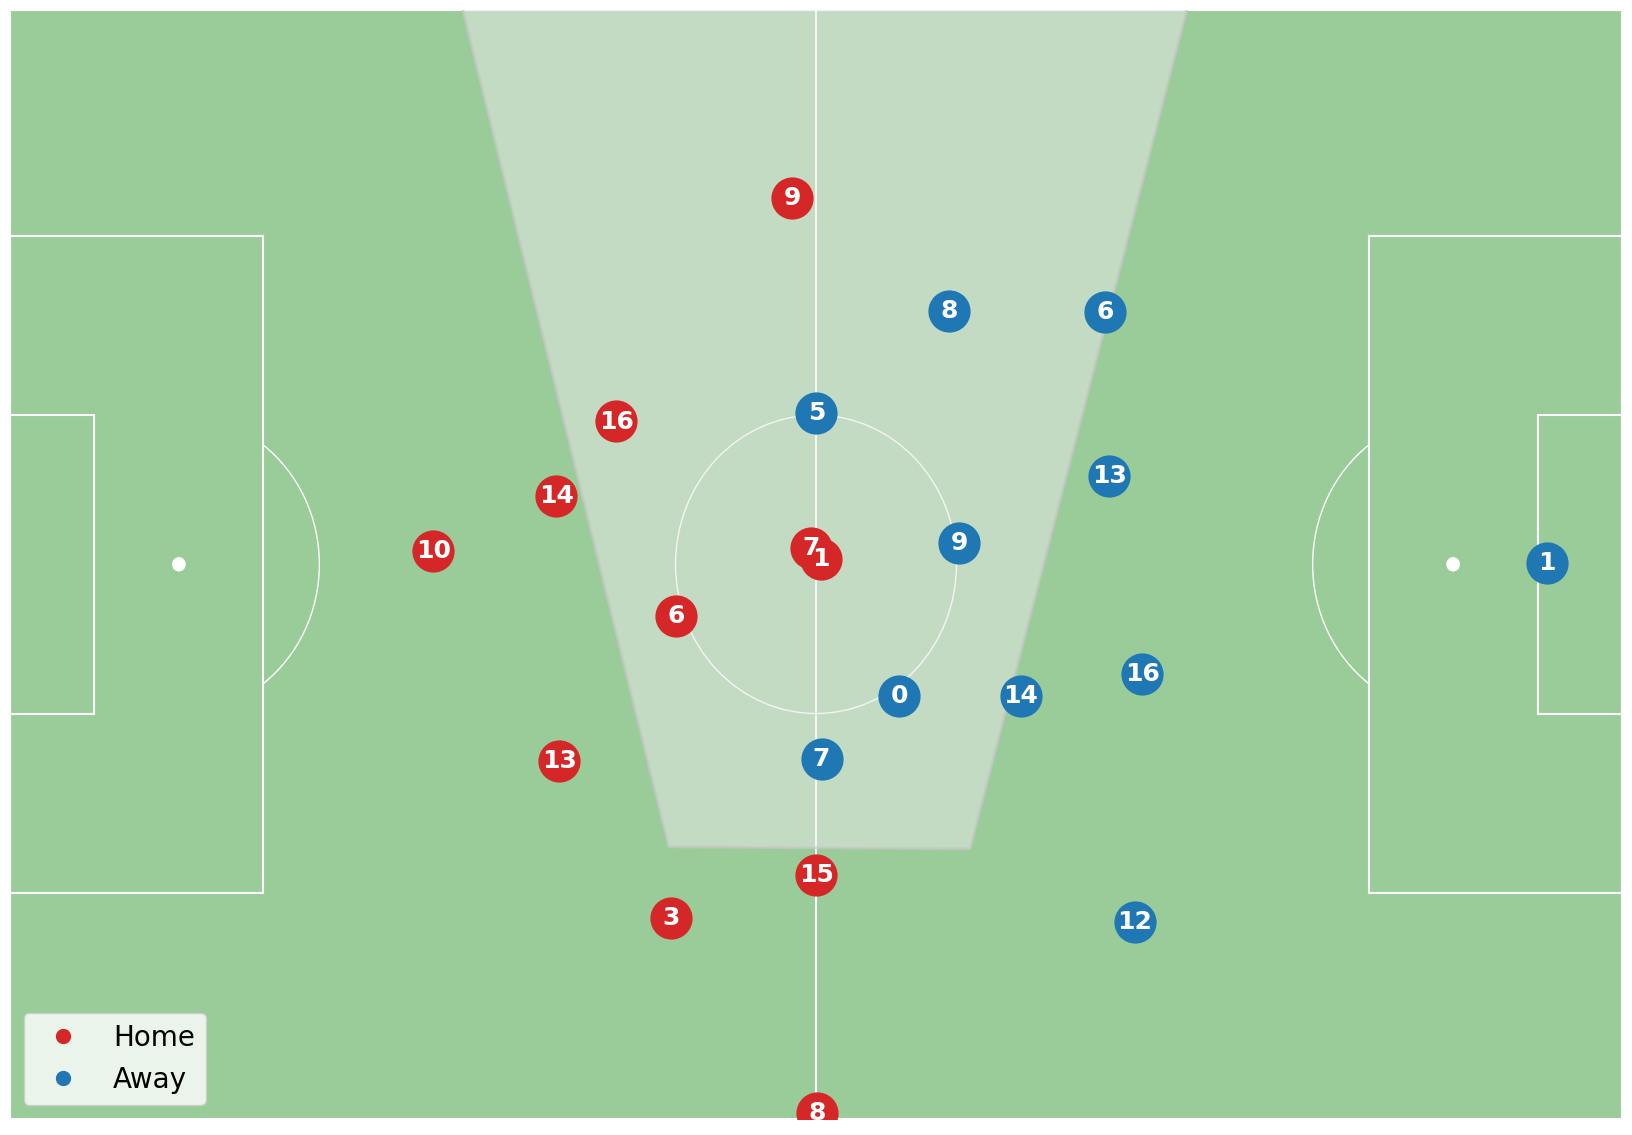

In [ ]:
event_id = 356#169#356	
before_maigin = 0
after_margin = 0

highlight = events[events["event_id"] == event_id].iloc[0]

period_traces = tracking_data[tracking_data["period_id"] == highlight.period_id].reset_index(drop=True)
closest_idx = period_traces["time"].sub(highlight.time_seconds).abs().idxmin()
trace = period_traces.loc[[closest_idx]].drop(columns=["B00_x", "B00_y"])

# 시각화: 360에 포착되지 않는 선수 제거
# except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01"]
# trace = trace.drop(columns=[f"{key}_{coord}" for key in except_id for coord in ["x", "y"]])

visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
# snapshot.plot(save_format="png")
snapshot.plot()

visible_area:  ((array([27.08966455]), array([99.11408272])), (array([90.05104534]), array([95.86098931])), (array([65.29096934]), array([19.4655954])), (array([43.84450669]), array([20.57369286])))
not exist ball trajectory


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

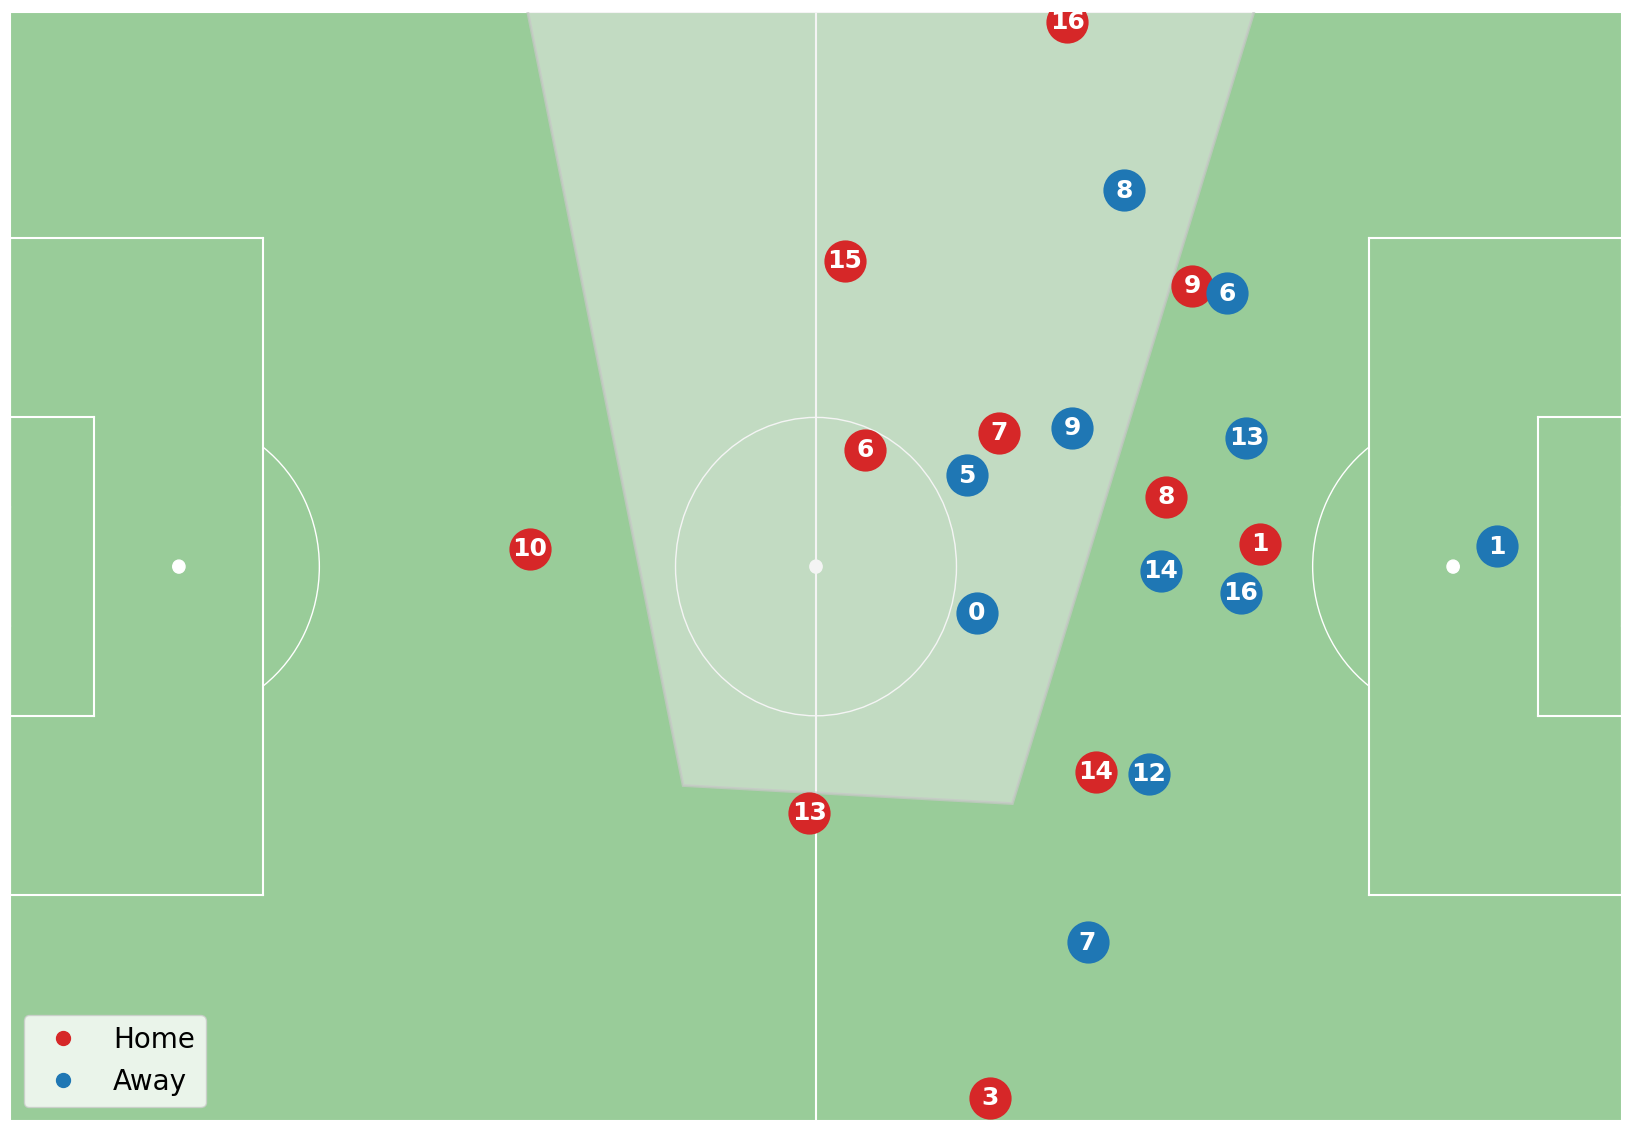

In [20]:
highlight = events[events["event_id"] == event_id].iloc[0]

row = {}
for pid, (x, y) in df.loc[event_id, "target"].items():
    row[f"{pid}_x"] = x
    row[f"{pid}_y"] = y
trace = pd.DataFrame.from_dict(row, orient='index').T

visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
snapshot.plot()

visible_area:  ((array([27.08966455]), array([99.11408272])), (array([90.05104534]), array([95.86098931])), (array([65.29096934]), array([19.4655954])), (array([43.84450669]), array([20.57369286])))
not exist ball trajectory


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

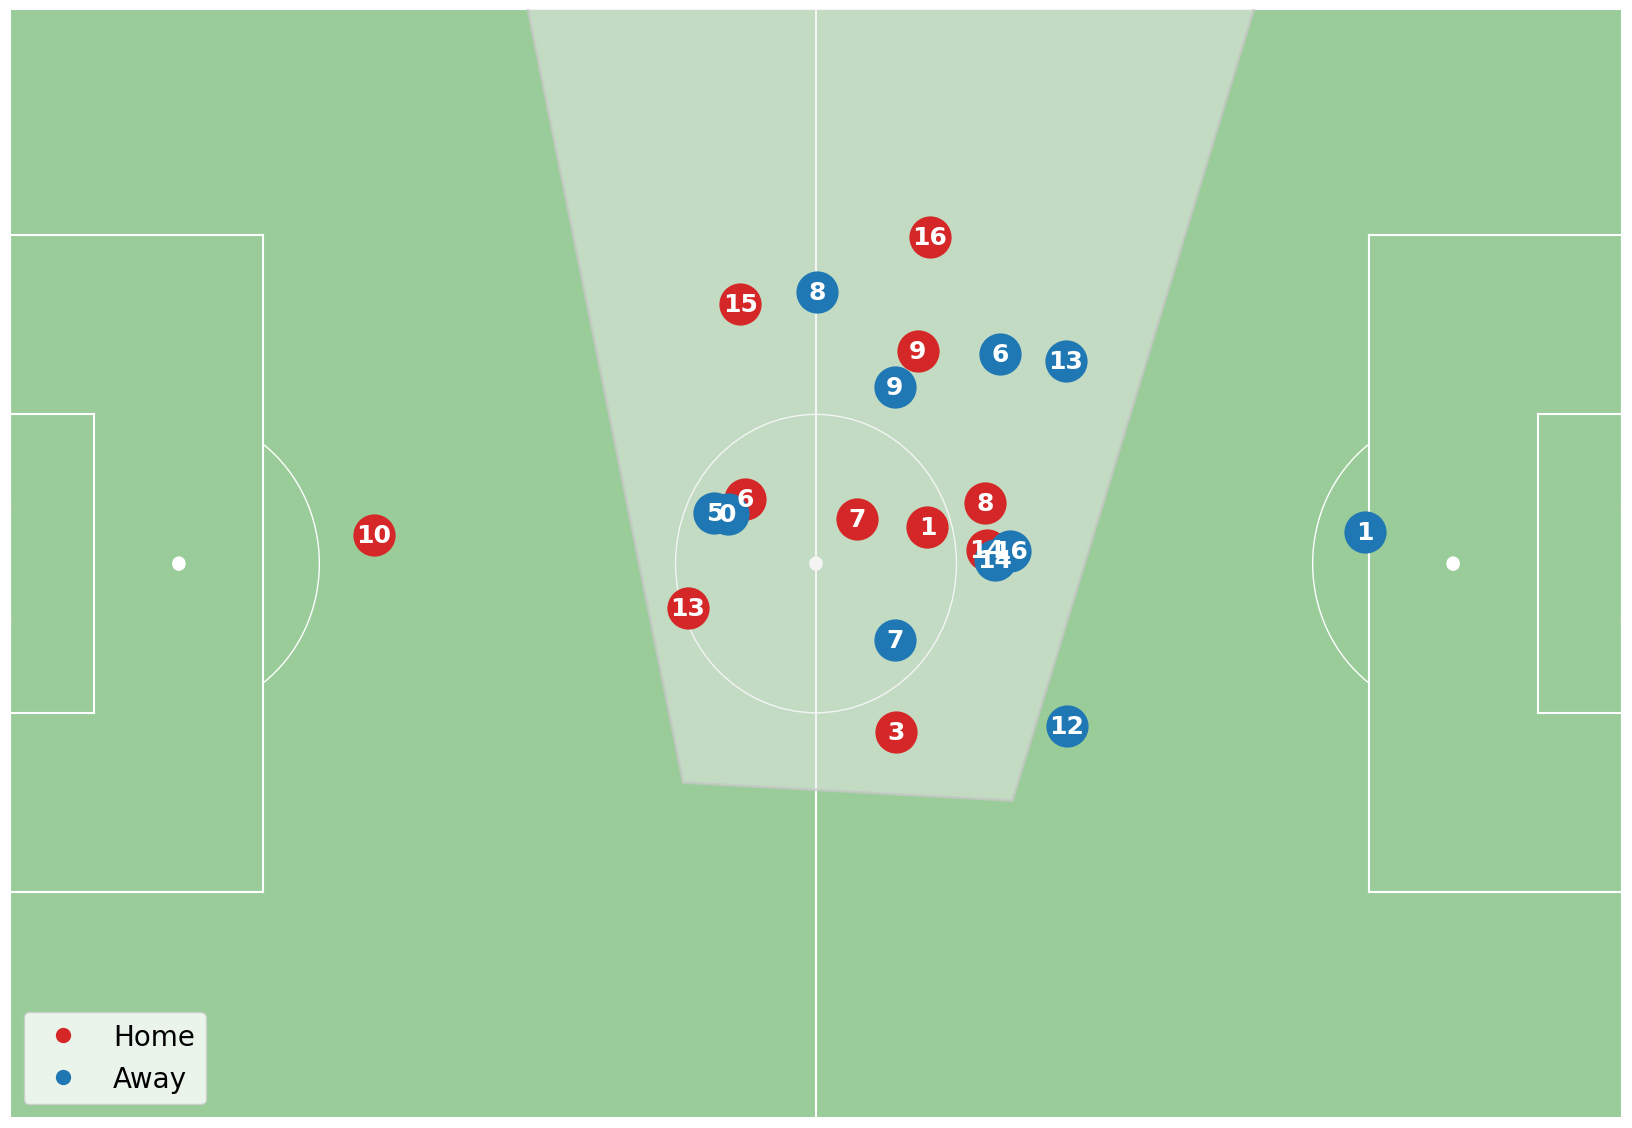

In [22]:
highlight = events[events["event_id"] == event_id].iloc[0]

row = {}
for pid, (x, y) in df.loc[event_id, "pred"].items():
    row[f"{pid}_x"] = x
    row[f"{pid}_y"] = y
trace = pd.DataFrame.from_dict(row, orient='index').T

# 시각화: 360에 포착되지 않는 선수 제거
# except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01", "A05","A00","A09","A08","H16", "H15","H07"]
# except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01"]
# trace = trace.drop(columns=[f"{key}_{coord}" for key in except_id for coord in ["x", "y"]])

visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
snapshot.plot()